In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# for interactive plots replace 'inline' with 'widget' and run in standalone jupyter notebook/lab
import os
from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData as SepiaData
import numpy as np
import sepia.SepiaPlot as SepiaPlot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from nedderimp import nedderimp
from scipy.interpolate import interp2d
from copy import deepcopy

def dist2pi(x1,x2):
    # computes the distance assuming periodicity: 2pi=0
    # x1 and x2 are vectors with common length and values
    # between 0 and 2pi
    d = abs(x1-x2)
    iwrap = d > np.pi
    d[iwrap] = 2*np.pi - d[iwrap]
    return(d)
def dnorm(x,mu,scale):  
    # normal density in 1-d. 
    # It is scaled so that the 1-d integral is 1
    # mu and scale are scalars, x is an array...
    out=np.zeros(len(x))
    u=abs(x-mu)/scale
    out = (1.0/(np.sqrt(2*np.pi)*scale)) * np.exp(-.5 * u**2)
    return(out)

In [2]:
# simulation design
design = np.array([
    [0.7714,    0.4286,    0.0286],
    [0.3714,    0.1143,    0.7143],
    [0.1714,    0.4571,    0.8857],
    [0.3429,    0.6000,    0.8000],
    [0.8000,    0.6286,    0.4000],
    [0.7429,    0.5429,         0],
    [0.6571,    1.0000,    0.6286],
    [0.2857,         0,    0.4571],
    [0.5143,    0.9429,    0.2286],
    [0.6857,    0.3143,    0.6571],
    [0.8286,    0.2000,    1.0000],
    [0.9714,    0.3429,    0.6000],
    [0.4000,    0.8000,    0.2000],
    [0.5429,    0.2857,    0.2857],
    [0.9143,    0.8857,    0.2571],
    [0.0571,    0.0286,    0.0857],
    [0.1143,    0.5714,    0.7429],
    [0.2000,    0.2286,    0.3714],
    [0.4571,    0.9143,    0.3429],
    [0.6286,    0.7143,    0.6857],
    [     0,    0.8286,    0.9429],
    [0.8857,    0.0857,    0.9714],
    [0.2286,    0.0571,    0.5714],
    [0.7143,    0.1714,    0.8571],
    [0.2571,    0.4857,    0.1429],
    [0.5714,    0.4000,    0.8286],
    [0.9429,    0.6857,    0.4857],
    [0.4857,    0.1429,    0.1143],
    [1.0000,    0.8571,    0.9143],
    [0.6000,    0.6571,    0.5143],
    [0.1429,    0.7429,    0.5429],
    [0.8571,    0.2571,    0.0571],
    [0.3143,    0.3714,    0.4286],
    [0.4286,    0.7714,    0.7714],
    [0.0286,    0.9714,    0.3143],
    [0.0857,    0.5143,    0.1714]])

# number of experiements and simulations
n = 3; m = design.shape[0]

# these parameter values simulate expt 10 in Neddermeyer '43
# params =             [R1      lam     s         rho   mratio   u0]
params10 = np.array([1.5*2.54, 2/3,  3e5*6.84e4,  7.5,   .32,   1.65e10])
paramslhs = np.zeros((m, 6))
for i in range(m):#
    paramslhs[i,:] = params10*np.array([1, 1, design[i,1]*.2+.9, 1, design[i,0]*.65+.5, design[i,2]*.2+.9])
# the simulation runs will vary mratio from .32*[.5 to 1.15]
#                                s      from s0*[.9 to 1.1]
#                                u0     from u0*[.9 to 1.1]

### A plot of the implosion over time

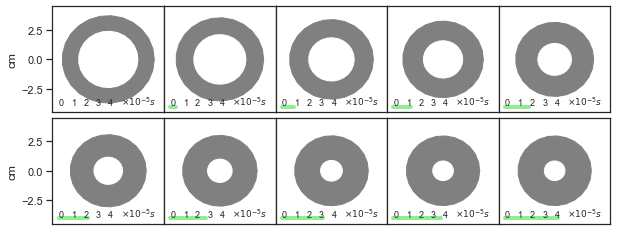

In [3]:
nt = 22; nphi = 26
time = np.c_[np.linspace(0,5.0e-5,nt,endpoint=True)]
phi = np.linspace(0,1,nphi,endpoint=True) * 2*np.pi;
rinner = nedderimp(time,params10);
lam = params10[1]; R1 = params10[0];
router = np.sqrt(rinner**2 + 1 - lam**2);
xycirc = np.array([np.cos(phi),np.sin(phi)]).T
r = nedderimp(time,params10);

fig, axs = plt.subplots(2,5,figsize=[10,4])
tframes = np.arange(1,nt,2)
time_text = ['0','1','2','3','4',r'$\times 10^{-5} s$']
time_x_loc = np.arange(-4,2,1)
time_y_loc = -3.9
for j,ax in enumerate(axs.flatten()):
    it = tframes[j]
    outer_circle = xycirc*router[it]*R1
    ax.fill(outer_circle[:,0],outer_circle[:,1],c='gray')
    inner_circle = xycirc*rinner[it]*R1
    ax.fill(inner_circle[:,0],inner_circle[:,1],c='white')
    ax.set_xlim([-4.5,4.5]); ax.set_ylim([-4.5,4.5])
    for i in range(len(time_text)):
        ax.text(time_x_loc[i],time_y_loc,time_text[i],fontsize=9)
    ax.plot((time[0:it]/(6e-5)*6)-4,np.repeat(-4,time[0:it].shape[0]),'lightgreen',linewidth=4)
    ax.get_xaxis().set_ticks([])
    if j == 0 or j == 5: ax.set_ylabel('cm')
    else: ax.get_yaxis().set_visible(False)
        
plt.subplots_adjust(wspace=0,hspace=0.05)
plt.show()

# Generate simulation data

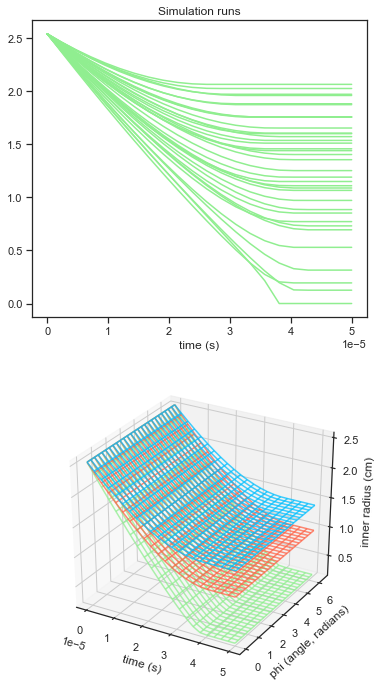

In [4]:
fig = plt.figure(figsize=[6,12])
ax1 = fig.add_subplot(211)
yr = np.zeros((m,nt))
for i in range(m):
    params = paramslhs[i,:]
    yr[i,:] = params[0]*nedderimp(time,params)
    ax1.plot(time,yr[i,:],c='lightgreen')
ax1.set_xlabel('time (s)'); ax.set_ylabel('inner radius (cm)')
ax1.set_title('Simulation runs')

y_sim = np.tile(yr,nphi)
ax2 = fig.add_subplot(212, projection='3d')
example_runs = [0,1,28]
colors = ['tomato','deepskyblue','lightgreen']
for i in range(len(example_runs)):
    ax2.plot_wireframe(time,phi,y_sim[example_runs[i],:].reshape(nt,nphi,order='F'),color=colors[i],alpha=.75)
ax2.set_xlabel('time (s)'); ax2.set_ylabel('phi (angle, radians)'); ax2.set_zlabel('inner radius (cm)')

plt.show()
# indices
y_sim_ind_time_phi = np.zeros((22*26,2))
y_sim_ind_time_phi[:,0] = np.repeat(time,26)
y_sim_ind_time_phi[:,1] = np.tile(phi,22)
x_sim = design[:,0].reshape(m,1)
t_sim = design[:,1:3]

# Generate observed data

In [5]:
phi_obs = np.arange(0,(2*np.pi-.1),(2*np.pi/16))
n_phi_obs = phi_obs.shape[0]
time_obs = [np.array([1.5e-5, 2.7e-5, 4.5e-5]),np.array([4.5e-5]),np.array([2.5e-5, 4.5e-5])]
n_time_obs = [tmp.shape[0] for tmp in time_obs]

phiknots = np.arange(0,2*np.pi-.1,2*np.pi/8)
dknots = np.expand_dims(np.array([.04, -.03, .03, -.03, .02, -.03, .03, -.03]),1)*2.5
pphiknots = len(phiknots)
Ddelt = np.zeros((phi_obs.shape[0], pphiknots));
datadelt = np.matmul(Ddelt,dknots)

# observations
r_obs = [None]*3; y_obs = [None]*3
for i in range(3):
    obs_params = deepcopy(params10)
    if i==1: obs_params[4]=.17
    elif i==2: obs_params[4]=.36
    r_obs[i] = np.atleast_2d(obs_params[0]*nedderimp(time_obs[i],obs_params))
    y_obs[i] = np.tile(r_obs[i].T,phi_obs.shape[0]).reshape(n_phi_obs,n_time_obs[i]) + np.tile(datadelt,n_time_obs[i])
    y_obs[i] = (y_obs[i] + .01*np.random.normal(size=y_obs[i].shape)).flatten()

# indices of observations
x_obs = ((np.array([params10[4], .17, .36])/.32-.5)/.65).reshape(3,1)
y_ind_obs = [np.column_stack( ( np.concatenate((np.ones(phi_obs.shape[0])*time_obs[0][0],\
                                   np.ones(phi_obs.shape[0])*time_obs[0][1],\
                                       np.ones(phi_obs.shape[0])*time_obs[0][2])), np.tile(phi_obs,3).T ) ),
                np.column_stack( ( (np.ones(phi_obs.shape[0])*time_obs[1]).reshape(16,1), phi_obs.T ) ),
                np.column_stack( ( np.concatenate((np.ones(phi_obs.shape[0])*time_obs[2][0],\
                                   np.ones(phi_obs.shape[0])*time_obs[2][1])), np.tile(phi_obs,2).T ) )]

### Sepia Data

In [6]:
data = SepiaData(x_sim = x_sim, t_sim = t_sim, y_sim = y_sim, y_ind_sim = y_sim_ind_time_phi,\
                 x_obs = x_obs, y_obs = y_obs, y_ind_obs = y_ind_obs)
data.transform_xt()

### K basis

In [7]:
# sim
ysimmean = np.mean(y_sim,0)
ysimsd = np.std(y_sim)
ysimStd = (y_sim - np.tile(ysimmean,m).reshape(y_sim.shape))/ysimsd
data.sim_data.orig_y_mean = ysimmean
data.sim_data.orig_y_sd = ysimsd
data.sim_data.y_std = ysimStd
# now represent ye images using eof's
U, s, V = np.linalg.svd(ysimStd.T, full_matrices=False)
numPC = 3
data.sim_data.K = U[:,0:numPC]*s[0:numPC]/np.sqrt(m)
data.sim_data.K = data.sim_data.K.T

# obs
phimat = np.repeat(phi,nt).reshape((nt,nphi),order='F')
timemat = np.repeat(time,nphi).reshape((nt,nphi))
# compute simulator mean values simdat.ymean interpolated to the data values...
interp_func = interp2d(phimat[0,:],timemat[:,0],data.sim_data.orig_y_mean.reshape((nt,nphi),order='F'))
data.obs_data.orig_y_mean = []
data.obs_data.orig_y_sd = []
for k in range(n):
    ymk = interp_func(np.unique(data.obs_data.y_ind[k][:,1]),np.unique(data.obs_data.y_ind[k][:,0]))                                                                             
    data.obs_data.orig_y_mean.append(ymk.flatten())
    data.obs_data.orig_y_sd.append(data.sim_data.orig_y_sd)

# now compute the centered, scaled observed arrival times yStd
data.obs_data.y_std = []
for k in range(n):
    data.obs_data.y_std.append((data.obs_data.y[k] - data.obs_data.orig_y_mean[k])/data.sim_data.orig_y_sd)

data.obs_data.K = []
for k in range(n):
    data.obs_data.K.append(np.zeros((data.obs_data.y_std[k].shape[0], numPC)))
    for j in range(numPC):
        f = interp2d(phimat[0,:],timemat[:,0],np.reshape(data.sim_data.K[j,:],(nt,nphi),order='F'))
        data.obs_data.K[k][:,j] = f(data.obs_data.y_ind[k][:,1],data.obs_data.y_ind[k][:,0])[:,0]

for k in range(n):
    data.obs_data.K[k] = data.obs_data.K[k].T

In [8]:
### D basis

In [9]:
# compute the basis functions for the discrepancy function.
Dsim  = np.zeros((phi.shape[0], pphiknots))
for k in range(pphiknots):
    Ddelt[:,k] = dnorm(dist2pi(phi_obs,phiknots[k]*np.ones(phi_obs.shape[0])),0,np.pi/8).T;
    x = dist2pi(phi,phiknots[k]*np.ones(phi.shape[0])).flatten()
    Dsim[:,k] = dnorm(x=x,mu=0,scale=np.pi/8)

simdelt = np.matmul(Dsim,dknots)
timeknots = np.linspace(0,.5,3)*1e-4
ptimeknots=len(timeknots)
data.obs_data.D = []
for k in range(n):
    knotlocstime = np.reshape(np.repeat(timeknots,pphiknots),(ptimeknots*pphiknots, 1))
    knotlocsphi = np.expand_dims(np.tile(phiknots,ptimeknots),1)
    pv = knotlocstime.shape[0]
    Dobs = np.zeros((data.obs_data.y_std[k].shape[0], pv))
    if k == 0: Dsim = np.zeros((data.sim_data.y_std.shape[1], pv))
    for j in range(pv):
        Dobs[:,j] = dnorm(y_ind_obs[k][:,0],knotlocstime[j],.25*1e-4)*\
            dnorm(dist2pi(y_ind_obs[k][:,1],knotlocsphi[j]*np.ones(y_ind_obs[k][:,1].shape[0])),0,np.pi/8)
        if k == 0:
            Dsim[:,j] = dnorm(timemat.flatten('F'),knotlocstime[j],.25*1e-4)*\
                dnorm(dist2pi(phimat.flatten('F'),knotlocsphi[j]*np.ones(len(phimat.flatten()))),0,np.pi/8)
    if k == 0: data.sim_data.D = Dsim
    data.obs_data.D.append(Dobs.T)
# now normalize Dobs and Dsim so that it gives a var=1 process
dmax = np.amax(np.amax(np.matmul(data.sim_data.D,data.sim_data.D.T)))
for k in range(n):
    data.obs_data.D[k] /= np.sqrt(dmax)
data.sim_data.D /= np.sqrt(dmax)

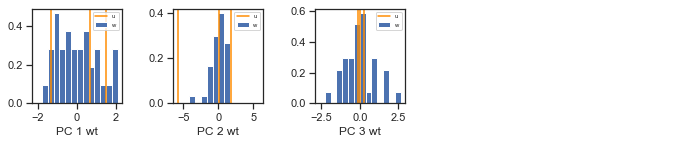

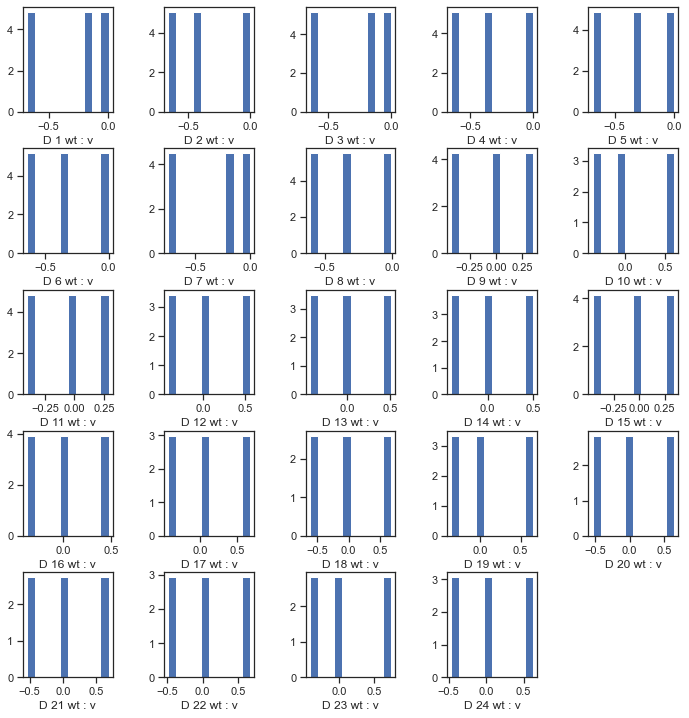

In [10]:
data.plot_K_weights()

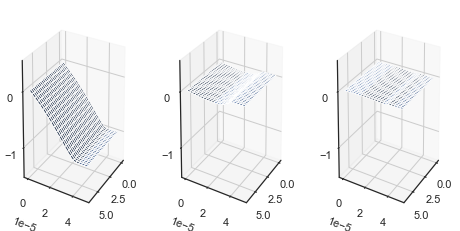

In [11]:
# plot K basis (simulation)
x,y = np.meshgrid(phi,time)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=plt.figaspect(0.5))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.plot_surface(x,y,data.sim_data.K[i,:].reshape((22,26),order='F'))
    ax.set_zlim([-1.5,.5])
    ax.view_init(20, 30)

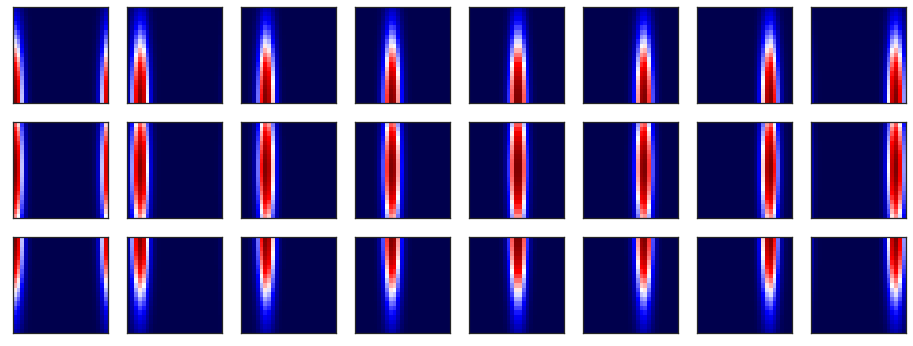

In [12]:
# plot D basis
fig, axs = plt.subplots(3,8,figsize=[16,6],sharex=True,sharey=True)
x,y = np.meshgrid(phi,time)
for i,ax in enumerate(axs.flatten()):
    ax.pcolormesh(x, y, data.sim_data.D[:,i].reshape((22,26),order='F'),cmap='seismic')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
plt.xlabel(r"angle \phi")
plt.ylabel("time")
plt.show()

Plotting up to 5 pairs. Change with parameter 'max_plots'


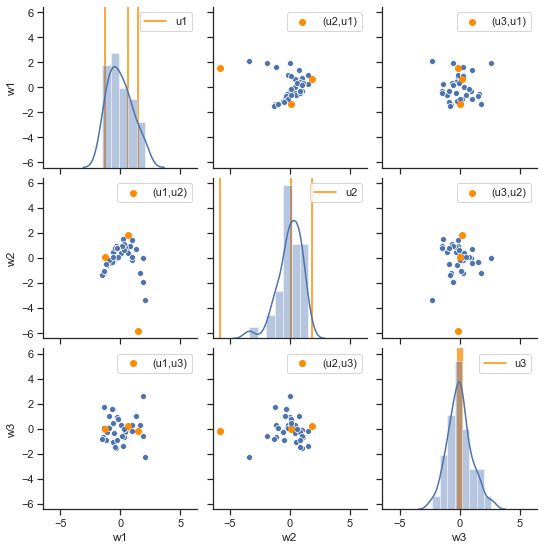

In [13]:
data.plot_u_w_pairs()

In [43]:
print(data)
model = setup_model(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 572, obs y dimension ragged
n  =     3 (number of observed data)
m  =    36 (number of simulated data)
p  =     1 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     3 (transformed response dimension)
pv =    24 (transformed discrepancy dimension)



In [44]:
model.verbose=False
opt_prm = model.optim_logPost(theta_only=False)
opt_prm['x']

optimizing logpost over all parameters
Optimization terminated successfully.
         Current function value: -93997.995263
         Iterations: 725
         Function evaluations: 1679


array([4.41939196e-01, 4.10091147e-01, 1.02317495e-01, 1.07813554e-01,
       9.64669516e-02, 1.00250938e-01, 9.75334305e-02, 1.05960153e-01,
       1.19107754e-01, 9.85476749e-02, 9.54525383e-02, 1.07080075e-01,
       2.08904713e+01, 9.76231459e-01, 1.04414546e+00, 9.83337312e-01,
       9.75556442e+02, 9.22357899e+02, 9.75551305e+02, 4.67869057e+04,
       2.27578324e+03])

In [16]:
override=0
cachefile_name='neddermeyer.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name) and override==0:
    model=pickle.load(open(cachefile_name, "rb" ))
else:
    model.tune_step_sizes(50, 20)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

Step size tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Starting tune_step_sizes...
Default step sizes:
theta
[[0.2 0.2]]
betaV
[[0.1]]
betaU
[[0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]]
lamVz
[[10.]]
lamUz
[[5. 5. 5.]]
lamWs
[[100. 100. 100.]]
lamWOs
[[100.]]
lamOs
[[1106.1703698]]


MCMC sampling:   0%|          | 0/5000 [00:00<?, ?it/s]

Done with tune_step_size.
Selected step sizes:
theta
[[0.13064111 0.16443439]]
betaV
[[0.73245673]]
betaU
[[0.98413382 0.43224493 0.81011891]
 [0.05076249 0.82637139 0.17321091]
 [0.08109625 0.39149985 0.82727331]]
lamVz
[[77835.22996821]]
lamUz
[[0.91835844 0.51615874 1.04468589]]
lamWs
[[4000.1323706  5763.08677353 4952.25722086]]
lamWOs
[[3835.84126542]]
lamOs
[[4558.32339074]]


MCMC sampling: 100%|██████████| 5000/5000 [01:06<00:00, 75.02it/s]


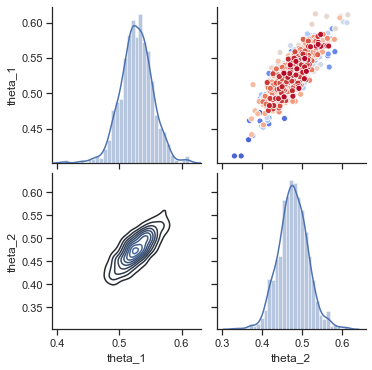

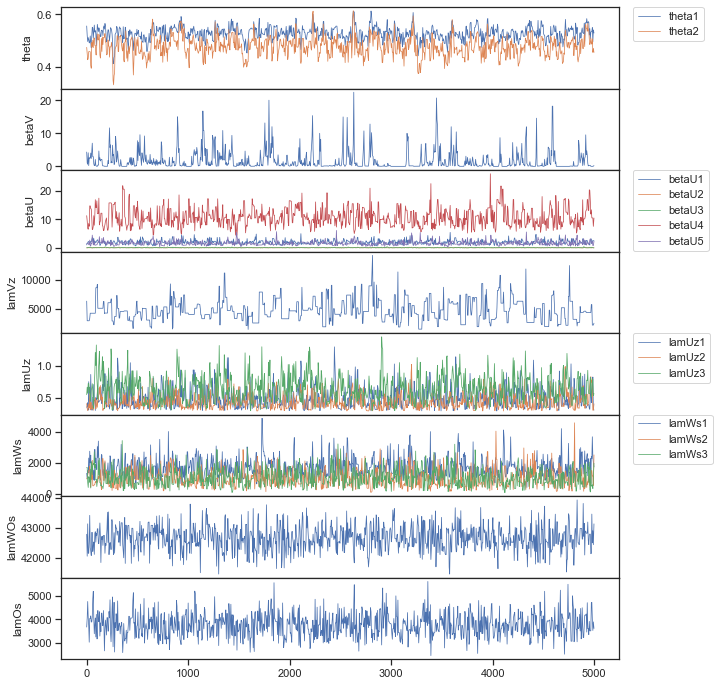

In [17]:
samples_dict = {p.name: p.mcmc_to_array(trim=0) for p in model.params.mcmcList}
SepiaPlot.theta_pairs(samples_dict)
SepiaPlot.mcmc_trace(samples_dict,start=0,n_to_plot=1000,max_print=5)

In [18]:
model.verbose=True
from sepia.SepiaPredict import SepiaEmulatorPrediction 
# get ESS number of samples for preduction
pred_samples=model.get_samples(nburn=0,effectivesamples=True)
pred=SepiaEmulatorPrediction(x_pred=x_obs, samples=pred_samples, model=model)

Max effective sample size over thetas: 228
Total samples: 5000


Predicted emulator principle component weights for each of the three experimental inputs x

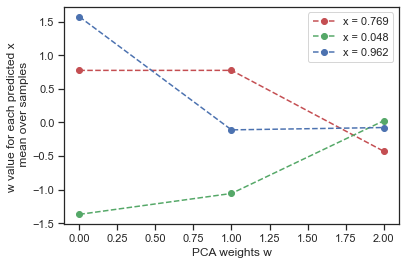

In [19]:
predw=pred.get_w()
plt.figure()
colors = ['r','g','b']
for i in range(3):
    plt.plot(np.mean(predw,0).T[:,i],'--o',c=colors[i],label='x = {}'.format(np.round(float(x_obs[i]),3)))
plt.legend()
plt.xlabel('PCA weights w')
plt.ylabel('w value for each predicted x \n mean over samples')
plt.show()

Predicted Simulator Output

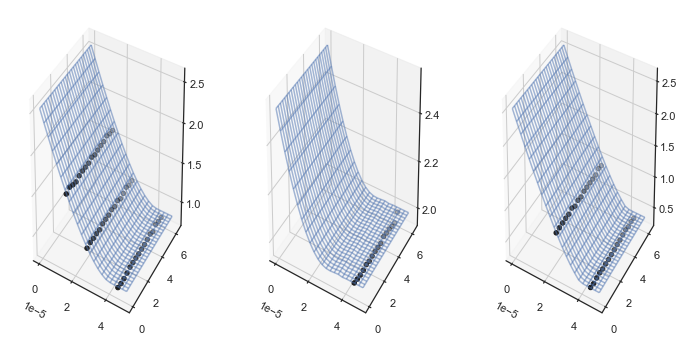

In [20]:
pred_time, pred_phi = np.meshgrid(time,phi)
predy=pred.get_y()

fig = plt.figure(figsize=[12,6])
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    ax.scatter(xs = y_ind_obs[i][:,0], ys = y_ind_obs[i][:,1], zs = y_obs[i],color='k')
    ax.plot_wireframe(pred_time,pred_phi,np.mean(predy,0)[i,:].reshape(26,22),
                      alpha=.5)

Predicted 

In [21]:
from sepia.SepiaPredict import SepiaFullPrediction
predfull = []
for i in range(3):
    predfull.append(SepiaFullPrediction(x_pred=np.atleast_2d(x_obs[i]), samples=pred_samples, model=model))

In [22]:
pred_d = []
pred_sim = []
pred_obs = []
for i in range(3):
    pred_d.append(predfull[i].get_discrepancy())
    pred_sim.append(predfull[i].get_ysim())
    pred_obs.append(predfull[i].get_yobs(obs_ref=i))
sim_grid_shape = (26,22)

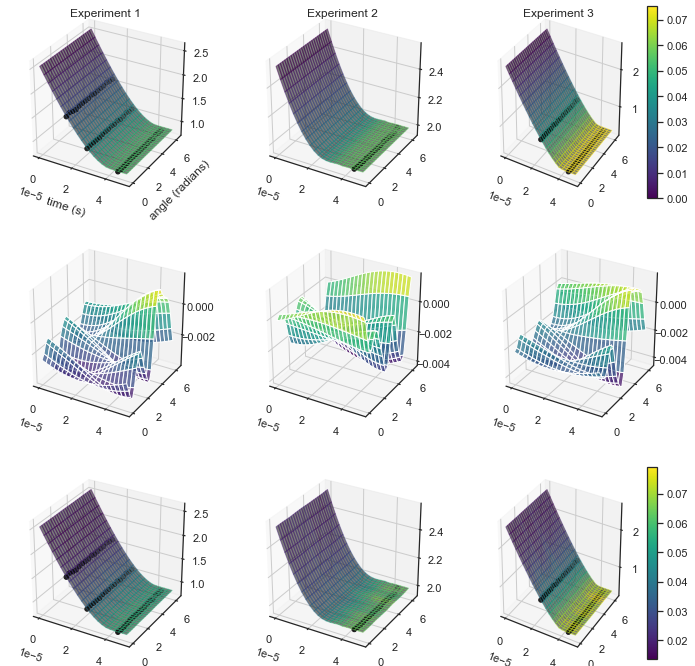

In [23]:
from matplotlib import cm
full_pred = [None]*n
quant_diff_full = [None]*n
quant_diff_sim = [None]*n
for i in range(n):
    full_pred[i] = pred_sim[i] + pred_d[i]
    # quantile range
    quant_diff_full[i] = np.abs(np.quantile(full_pred[i],.95,0)-np.quantile(full_pred[i],.05,0))
    quant_diff_sim[i]  = np.abs(np.quantile(pred_sim[i],.95,0)-np.quantile(pred_sim[i],.05,0))
    
# color sim surface by uncertainty
c_min = min([np.amin(tmp) for tmp in quant_diff_sim[i]])
c_max = max([np.amax(tmp) for tmp in quant_diff_sim[i]])
norm = plt.Normalize(c_min, c_max)
colors_sim = [None]*n
for i in range(n):
    colors_sim[i] = cm.viridis(norm(quant_diff_sim[i])).squeeze()
    colors_sim[i] = colors_sim[i].reshape((26,22,4))
cmap_sim = cm.ScalarMappable(cmap='viridis', norm=norm)
cmap_sim.set_array([])
    
# color full surface by uncertainty
c_min = min([np.amin(tmp) for tmp in quant_diff_full[i]])
c_max = max([np.amax(tmp) for tmp in quant_diff_full[i]])
norm = plt.Normalize(c_min, c_max)
colors_full = [None]*n
for i in range(n):
    colors[i] = cm.viridis(norm(quant_diff_full[i])).squeeze()
    colors[i] = colors[i].reshape((26,22,4))  
cmap_full = cm.ScalarMappable(cmap='viridis', norm=norm)
cmap_full.set_array([])
    
fig = plt.figure(figsize=[12,12])
for i in range(9):
    ax = fig.add_subplot(3,3,i+1,projection='3d')
    if i in [0,1,2]:
        ax.scatter(xs = y_ind_obs[i][:,0], ys = y_ind_obs[i][:,1], zs = y_obs[i],color='k')
        if i == 0: ax.set_xlabel('time (s)'); ax.set_ylabel('angle (radians)'); 
        ax.set_title('Experiment {}'.format(i+1))
        surf = ax.plot_surface(pred_time,pred_phi,np.mean(pred_sim[i],0).reshape(sim_grid_shape), shade=False, alpha=.5, facecolors=colors_sim[i])
        surf.set_facecolor((0,0,0,0))
        if i == 2: plt.colorbar(cmap_sim)
    elif i in [3,4,5]:
        ax.plot_surface(pred_time,pred_phi,np.mean(pred_d[i-3],0).reshape(sim_grid_shape),alpha=.75, shade=False, cmap = 'viridis')
    else:
        ax.scatter(xs = y_ind_obs[i-6][:,0], ys = y_ind_obs[i-6][:,1], zs = y_obs[i-6],color='k')
        surf = ax.plot_surface(pred_time,pred_phi,np.mean(full_pred[i-6],0).reshape(sim_grid_shape), shade=False, alpha=.5,facecolors=colors[i-6])
        surf.set_facecolor((0,0,0,0))
        if i == 8: plt.colorbar(cmap_full)
plt.show()

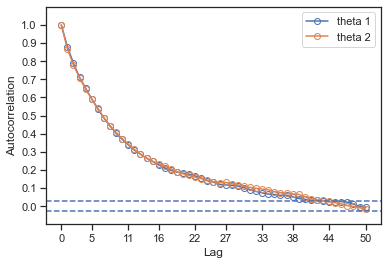

Effective Sample Sizes: [228, 225]
Total number of samples: [5000, 5000]


In [24]:
acf = SepiaPlot.plot_acf(model,nlags=50,nburn=0)